In [89]:
import requests
import pandas as pd
import numpy as np

from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
import time
from xgboost import XGBRegressor
import json
from scipy.fft import fft
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import GridSearchCV


In [174]:
c_br_green1 = '#76FF78'
c_br_green2 = '#90EE90'
c_br_green3 = '#9ACD32'
c_turq = '#06C2AC'
c_dark_green = '#054907'
c_yellow = '#FFD700'
c_blue = '#7BC8F6'

In [175]:
# Data was previously saved
with open('data.json') as f:
    resp_json = json.load(f)

# Transform response to a df
data = {
    "Datetime" : resp_json["unix_seconds"]
}

for i in resp_json["production_types"]:
  if (i["name"] == "Wind onshore") or (i["name"] == "Solar") or (i["name"] == "Wind offshore"):
    data[i["name"]] = i["data"]

df = pd.DataFrame.from_dict(data)

# Initial preprocessing

# Getting total power produced from all three energy sources
df['Total power'] = df.loc[:, df.columns != "Datetime"].apply(np.sum, axis=1)

# Convert to datetime and local timezone
df['Datetime'] = pd.to_datetime(df['Datetime'], unit='s')
df['Datetime'] = df['Datetime'].dt.tz_localize("UTC")
df['Datetime'] = df['Datetime'].dt.tz_convert(tz = 'Europe/Berlin')

df = df.set_index('Datetime')

# Get hourly data as prediction will be per hour
df = df.resample('1h').sum()
df

,Wind offshore,Wind onshore,Solar,Total power
Datetime,,,,
2015-01-01 01:00:00+01:00,2083.0,36655.4,0.0,38738.4
2015-01-01 02:00:00+01:00,2076.0,37263.4,0.0,39339.4
2015-01-01 03:00:00+01:00,2090.0,37062.4,0.0,39152.4
2015-01-01 04:00:00+01:00,2098.3,37294.1,0.0,39392.4
2015-01-01 05:00:00+01:00,2097.4,38539.5,0.0,40636.9
...,...,...,...,...
2024-08-31 22:00:00+02:00,12782.9,61676.5,0.0,74459.4
2024-08-31 23:00:00+02:00,12281.4,61475.8,0.0,73757.2
2024-09-01 00:00:00+02:00,10666.8,59812.4,0.0,70479.2


In order to use a traditional machine learning to make the wanted prediction, I will treat this as a regression. Let's create some additional features that can help to train the model.

## 2.2. Feature Engineering

In [176]:
df['Hour'] = df.index.hour 
df["Week of year"] = df.index.isocalendar().week
df["Day of year"] = df.index.dayofyear
df['Month'] = df.index.month 
df["Quarter"] = df.index.quarter
df['Year'] = df.index.year

def create_shift_feautures(df, steps):

    for i in range(1, steps + 1):
        df[f'day-{i}'] = df['Total power'].shift(i*24)

    return df

# Creating two more columns, with Total Power values for the same hour, yesterday and the day before yesterday
df = create_shift_feautures(df, steps=3)

# 3. Modelling

## 3.1. Split train and test data

In [177]:
dataframe = df.copy()
df = df.reset_index(drop=True)

In [178]:
def get_train_test(features, label, df):

    X = df[features]
    y = df[label]
    #80% train 20% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test

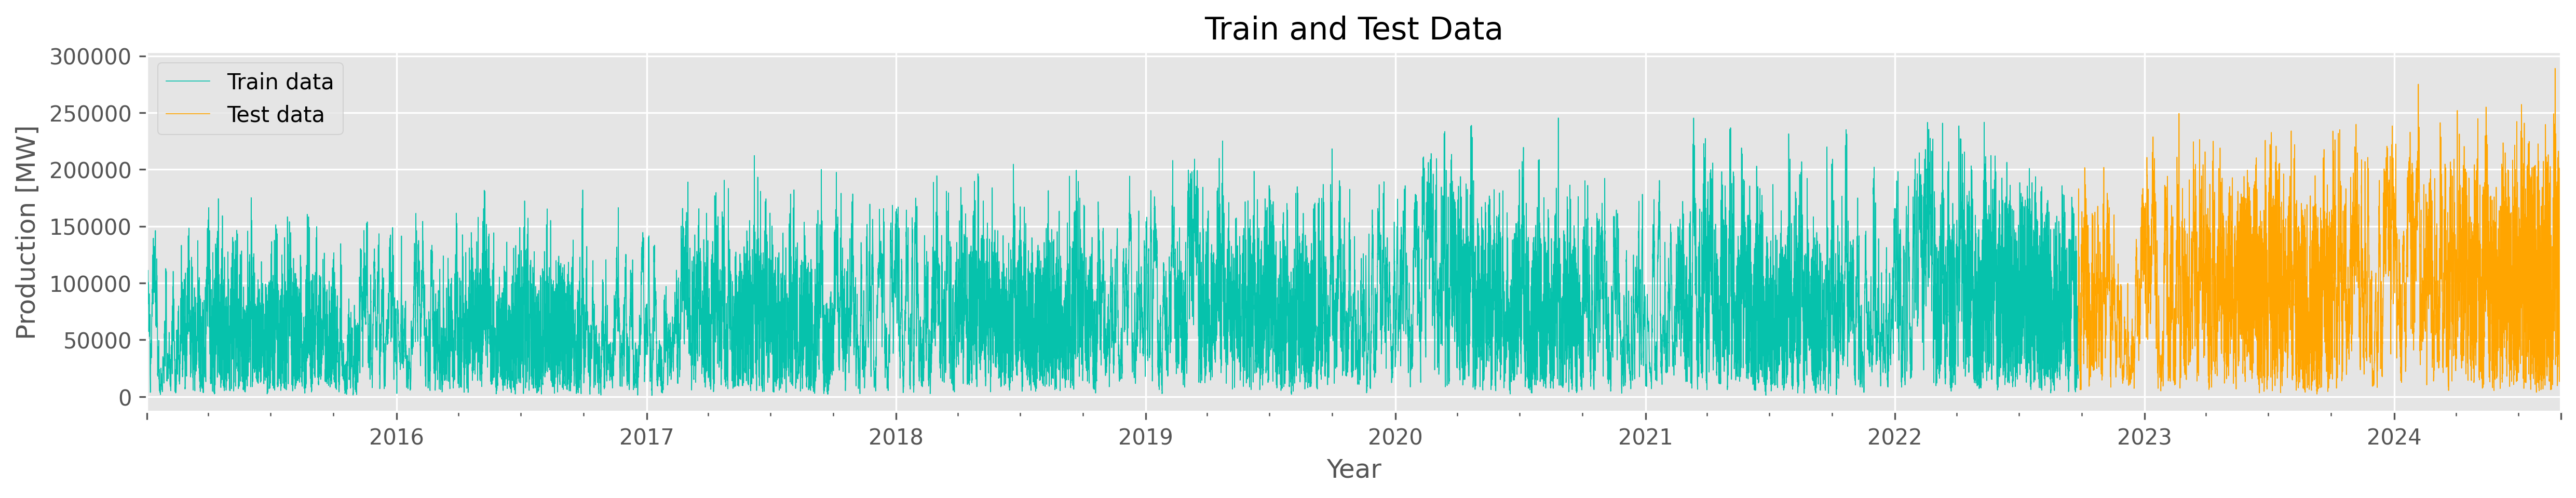

In [179]:
features = ['Year', 'Month', 'Hour']
label = 'Total power'
X_train, X_test, y_train, y_test = get_train_test(features, label, df)

plt.rcParams.update({'figure.figsize': (20, 3), 'figure.dpi':300})
plt.style.use('ggplot')
dataframe['Total power'][:int(len(df) * .8)].plot(label='Train data', legend = True, linewidth = .4, c=c_turq)
dataframe['Total power'][int(len(df) * .8):].plot(label='Test data', legend = True, linewidth = .4, c='orange')
plt.ylabel('Production [MW]')
plt.xlabel('Year')
plt.title('Train and Test Data')
plt.show()

## 3.2.1. Client's model

First, let's make predictions based on the client's model and see how it performs on our test data. On the premise that every wrongly predicted MWh carries a penalty of 50 Euro, I will calculate the cost and will later used it to compare its performance to my model's performance.

The client assumes that the production tomorrow will be the same as the production yesterday.

In [180]:
pred_client = df['day-2'][int(len(df) * .8):].copy()

mae = mean_absolute_error(y_test, pred_client)
mse = mean_squared_error(y_test, pred_client)
print('Mean Abs Error for client\'s model:', mae)
print('Mean Squaed Error for client\'s model:', mse)
print('Penalty on average for single prediction: {}'.format('{:,.2f}€'.format((mae)*50)))
print('Penalty: {}'.format('{:,.2f}€'.format(((y_test - pred_client).abs().sum())*50)))

Mean Abs Error for client's model: 37422.93902885125
Mean Squaed Error for client's model: 2299611843.1258965
Penalty on average for single prediction: 1,871,146.95€
Penalty: 31,714,069,680.00€


Assuming that the client has been using this model from Sept 25th, 22:00 Berlin time, it would have caused the client approx 31.7 billion euros. I will use this cost for comparison for my own model.

I will also be looking at MAE for evaluation. Considering that there is a constant 50 euro fee for every wrongly predicted MWh, MAE as the average of the absolute difference between actual and predicted values, seems to be the most clear metrics for evaluation.

## 3.2.2. XGBoost 

In [181]:
# Useful functions
def ready_for_model(X_train, X_test, y_train, y_test):
    
    X_train_ = X_train.values
    y_train_ = y_train.values
    X_test_ = X_test.values
    y_test_ = y_test.values

    return X_train_, X_test_, y_train_, y_test_
    
def xgboost(X_train, X_test, y_train, y_test, verbose, best_params):

    if best_params:
        model = XGBRegressor(**best_params)
    else:
        model = XGBRegressor()

    model.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)], verbose=verbose)
    
    return model

def evaluate(model, X_test, y_test):
    
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    print('Mean Abs Error:', mae)
    mse = mean_squared_error(y_test, pred)
    print('Mean Squaed Error:', mse)
    print('Penalty on average for single prediction: {}'.format('{:,.2f}€'.format((mae)*50)))
    print('Penalty: {}'.format('{:,.2f}€'.format(((pred - y_test).abs().sum())*50)))


def grid_search_best_param(X_train, y_train):
    
    param_grid = {'learning_rate': [0.01, 0.1, 0.2],'max_depth': [3, 5, 7],'subsample': [0.8, 0.9, 1.0]}

    grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    return best_params



In [182]:
features = ['Hour', 'Week of year', 'Day of year', 'Month', 'Quarter', 'Year']
label = 'Total power'
X_train, X_test, y_train, y_test = get_train_test(features, label, df)

X_train_, X_test_, y_train_, y_test_ = ready_for_model(X_train, X_test, y_train, y_test)
model_1 = xgboost(X_train_, X_test_, y_train_, y_test_, True, None)

evaluate(model=model_1, X_test=X_test, y_test=y_test)

[0]	validation_0-rmse:39475.97173	validation_1-rmse:52263.41097
[1]	validation_0-rmse:36433.76442	validation_1-rmse:49152.84781
[2]	validation_0-rmse:34524.78358	validation_1-rmse:46858.37172
[3]	validation_0-rmse:33330.65453	validation_1-rmse:45267.17092
[4]	validation_0-rmse:32605.25763	validation_1-rmse:44603.04213
[5]	validation_0-rmse:32060.84663	validation_1-rmse:44124.47449
[6]	validation_0-rmse:31651.73449	validation_1-rmse:43665.43591
[7]	validation_0-rmse:31360.17930	validation_1-rmse:43339.36982
[8]	validation_0-rmse:30744.03784	validation_1-rmse:43416.80195
[9]	validation_0-rmse:30420.31770	validation_1-rmse:43487.18880
[10]	validation_0-rmse:30159.41487	validation_1-rmse:43537.02689
[11]	validation_0-rmse:29923.49397	validation_1-rmse:43437.15969
[12]	validation_0-rmse:29780.90209	validation_1-rmse:43537.95287
[13]	validation_0-rmse:29599.46795	validation_1-rmse:43571.89614
[14]	validation_0-rmse:29054.16663	validation_1-rmse:43630.49961
[15]	validation_0-rmse:28895.40590	

MAE and penalty higher than client's model. Will train the model on only three features, which I think of as more important.
Hour, Month, Year

In [183]:
features = ['Year', 'Month', 'Hour']
label = 'Total power'
X_train, X_test, y_train, y_test = get_train_test(features, label, df)

X_train_, X_test_, y_train_, y_test_ = ready_for_model(X_train, X_test, y_train, y_test)
model_2 = xgboost(X_train_, X_test_, y_train_, y_test_, True, None)

evaluate(model=model_2, X_test=X_test, y_test=y_test)

[0]	validation_0-rmse:39724.81041	validation_1-rmse:52376.48375
[1]	validation_0-rmse:36879.61968	validation_1-rmse:49190.74206
[2]	validation_0-rmse:35118.47769	validation_1-rmse:45988.36345
[3]	validation_0-rmse:34147.82932	validation_1-rmse:44737.80892
[4]	validation_0-rmse:33561.80889	validation_1-rmse:43817.74427
[5]	validation_0-rmse:33197.71579	validation_1-rmse:43105.44286
[6]	validation_0-rmse:32985.46387	validation_1-rmse:42830.91517
[7]	validation_0-rmse:32856.41012	validation_1-rmse:42534.21606
[8]	validation_0-rmse:32742.61898	validation_1-rmse:42464.92117
[9]	validation_0-rmse:32590.69732	validation_1-rmse:42480.35660
[10]	validation_0-rmse:32503.09173	validation_1-rmse:42560.06743
[11]	validation_0-rmse:32466.88650	validation_1-rmse:42660.28550
[12]	validation_0-rmse:32382.57966	validation_1-rmse:42755.11489
[13]	validation_0-rmse:32356.56973	validation_1-rmse:42727.61810
[14]	validation_0-rmse:32313.94595	validation_1-rmse:42797.53237
[15]	validation_0-rmse:32247.98168	

Model performs better than client's model. 
I will add to the model 2 features that represent the total power production two days ago and three days ago respectively.

In [187]:
features = ['Year', 'Month', 'Hour', 'day-2', 'day-3']
label = 'Total power'

train = dataframe[:int(len(df) * .8)].copy()
test = dataframe[int(len(df) * .8):].copy()

# Dropping NaN
train.dropna(inplace = True)

X_train = train[features]
X_test = test [features]
y_train = train[label]
y_test = test[label]

X_train_, X_test_, y_train_, y_test_ = ready_for_model(X_train, X_test, y_train, y_test)
model_2 = xgboost(X_train_, X_test_, y_train_, y_test_, True, None)

evaluate(model=model_2, X_test=X_test, y_test=y_test)

[0]	validation_0-rmse:39383.62248	validation_1-rmse:51560.03936
[1]	validation_0-rmse:36232.23820	validation_1-rmse:46594.77043
[2]	validation_0-rmse:34430.66102	validation_1-rmse:44457.98333
[3]	validation_0-rmse:33363.41318	validation_1-rmse:42584.94401
[4]	validation_0-rmse:32697.84805	validation_1-rmse:41568.03130
[5]	validation_0-rmse:32246.49837	validation_1-rmse:40945.56197
[6]	validation_0-rmse:31928.34444	validation_1-rmse:40653.01264
[7]	validation_0-rmse:31693.34320	validation_1-rmse:40543.88853
[8]	validation_0-rmse:31518.85629	validation_1-rmse:40521.28477
[9]	validation_0-rmse:31350.05773	validation_1-rmse:40496.09669
[10]	validation_0-rmse:31142.91188	validation_1-rmse:40444.81982
[11]	validation_0-rmse:31022.00720	validation_1-rmse:40441.26929
[12]	validation_0-rmse:30789.06021	validation_1-rmse:40485.85370
[13]	validation_0-rmse:30710.94855	validation_1-rmse:40478.28614
[14]	validation_0-rmse:30611.72452	validation_1-rmse:40493.47585
[15]	validation_0-rmse:30469.39427	

Final model has MAE approx 33613 compared to the client's model's 37422. 
The penalty is approx 3 billion euros smaller. 

The final model outperforms the client's model. 

In [188]:
test['Predictions'] = model_2.predict(X_test)

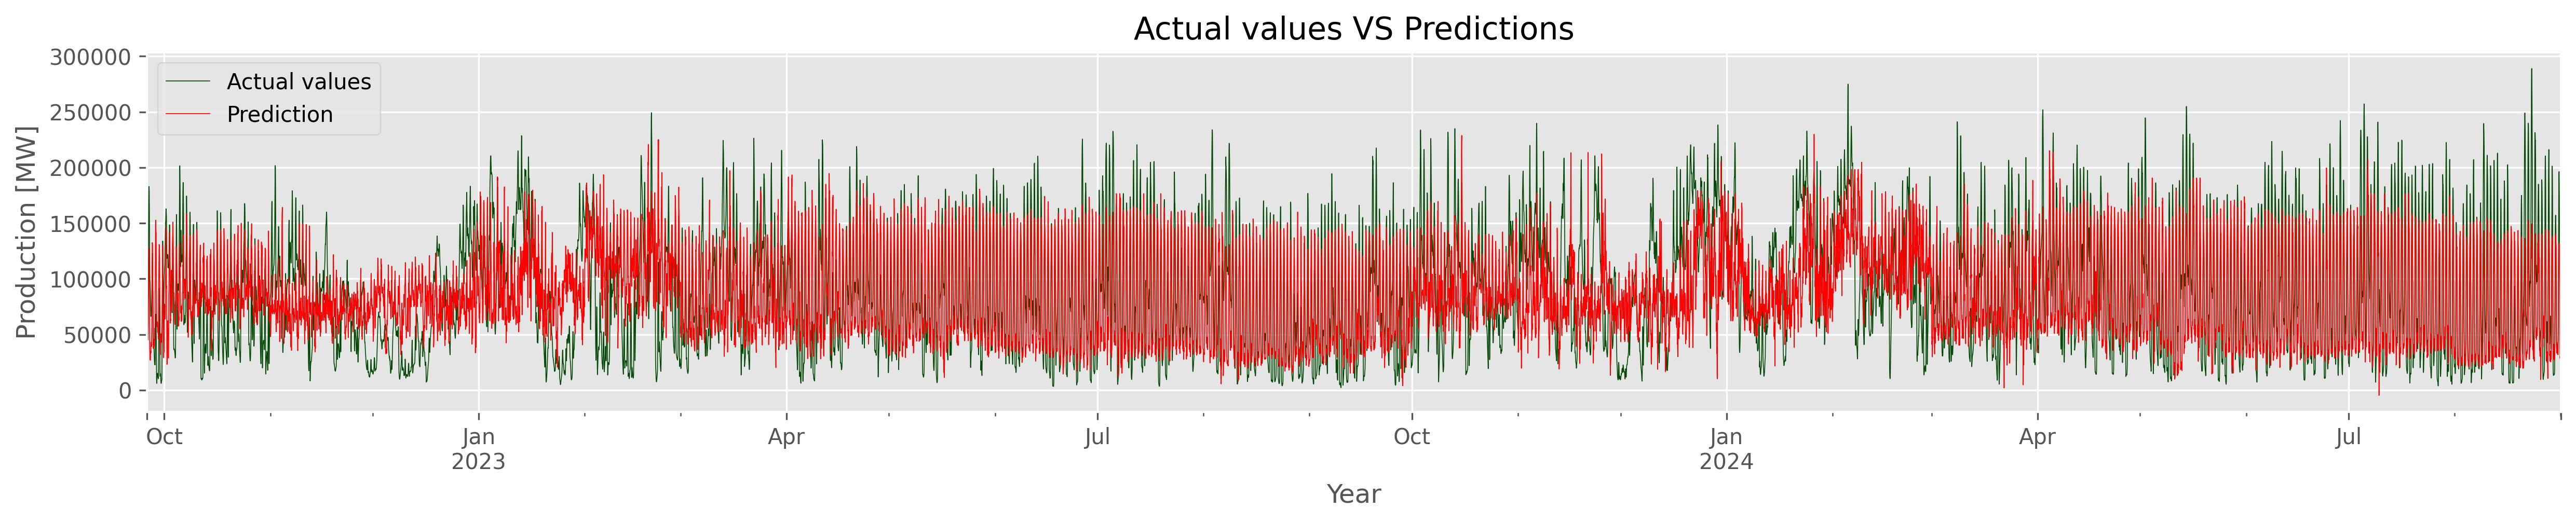

In [189]:
plt.rcParams.update({'figure.figsize': (20, 3), 'figure.dpi':300})
plt.style.use('ggplot')
test['Total power'].plot(label='Actual values', legend = True, linewidth = .4, c=c_dark_green)
test['Predictions'].plot(label='Prediction', legend = True, linewidth = .4, c='red')
plt.ylabel('Production [MW]')
plt.xlabel('Year')
plt.title('Actual values VS Predictions')
plt.show()